In [1]:
# make sure jupyter path is correct for loading local moudules
import sys
# path to steric_simulator module relative to notebook
sys.path.append("../../../")
import copy
from KineticAssembly_AD import ReactionNetwork, VectorizedRxnNet, VecSim, Optimizer, EquilibriumSolver, TrapMetric
import networkx as nx
import torch
from torch import DoubleTensor as Tensor

In [2]:
base_input = '../input_files/tetramer_diversification.pwr'
rn = ReactionNetwork(base_input, one_step=True)
rn.resolve_tree()

['default_assoc', 1.0]
['rxn_coupling', True]
True
['monomer_add_only', False]
[(0, {'struct': <networkx.classes.graph.Graph object at 0x000001442ACF3128>, 'copies': tensor([100.], dtype=torch.float64), 'subunits': 1}), (1, {'struct': <networkx.classes.graph.Graph object at 0x000001442ACE2828>, 'copies': tensor([100.], dtype=torch.float64), 'subunits': 1}), (2, {'struct': <networkx.classes.graph.Graph object at 0x000001442A3DC5F8>, 'copies': tensor([100.], dtype=torch.float64), 'subunits': 1}), (3, {'struct': <networkx.classes.graph.Graph object at 0x000001442A3DCB70>, 'copies': tensor([100.], dtype=torch.float64), 'subunits': 1})]
New node added - Node index: 4 ; Node label: AM 
New node added - Node index: 5 ; Node label: AB 
New node added - Node index: 6 ; Node label: AS 
New node added - Node index: 7 ; Node label: BM 
New node added - Node index: 8 ; Node label: MS 
New node added - Node index: 9 ; Node label: ABM 
New node added - Node index: 10 ; Node label: AMS 
New node added

In [3]:
uid_dict = {}
react_dict = {}
sys.path.append("../../")
nodes_list = []
import numpy as np
from reaction_network import gtostr
for n in rn.network.nodes():
    print(n,"--",gtostr(rn.network.nodes[n]['struct']))
    nodes_list.append(gtostr(rn.network.nodes[n]['struct']))
    for r_set in rn.get_reactant_sets(n):
        r_tup = tuple(list(r_set)+[n])
#         print(r_tup)
        data = rn.network.get_edge_data(r_tup[0], n)
        reaction_id = data['uid']
        react_dict[r_tup]=reaction_id
    for k,v in rn.network[n].items():
        uid = v['uid']
        r1 = set(gtostr(rn.network.nodes[n]['struct']))
        p = set(gtostr(rn.network.nodes[k]['struct']))
        r2 = p-r1
        reactants = ("".join(r1),"".join(r2))
#         print(reactants)
        uid_dict[(n,k)] = uid
#         react_dict[reactants] = uid

print(uid_dict)
print(react_dict)

0 -- A
1 -- M
2 -- B
3 -- S
4 -- AM
5 -- AB
6 -- AS
7 -- BM
8 -- MS
9 -- ABM
10 -- AMS
11 -- BS
12 -- ABS
13 -- BMS
14 -- ABMS
{(0, 4): 0, (0, 5): 1, (0, 6): 2, (0, 9): 19, (0, 10): 20, (0, 12): 21, (0, 14): 24, (1, 4): 0, (1, 7): 3, (1, 8): 4, (1, 9): 5, (1, 10): 6, (1, 13): 22, (1, 14): 23, (2, 5): 1, (2, 7): 3, (2, 11): 7, (2, 9): 8, (2, 12): 9, (2, 13): 10, (2, 14): 11, (3, 6): 2, (3, 8): 4, (3, 11): 7, (3, 10): 12, (3, 12): 13, (3, 13): 14, (3, 14): 15, (4, 9): 8, (4, 10): 12, (4, 14): 16, (5, 9): 5, (5, 12): 13, (5, 14): 17, (6, 10): 6, (6, 12): 9, (6, 14): 18, (7, 13): 14, (7, 14): 18, (7, 9): 19, (8, 13): 10, (8, 14): 17, (8, 10): 20, (9, 14): 15, (10, 14): 11, (11, 14): 16, (11, 12): 21, (11, 13): 22, (12, 14): 23, (13, 14): 24}
{(0, 1, 4): 0, (0, 2, 5): 1, (0, 3, 6): 2, (1, 2, 7): 3, (1, 3, 8): 4, (1, 5, 9): 5, (2, 4, 9): 8, (0, 7, 9): 19, (3, 4, 10): 12, (1, 6, 10): 6, (8, 0, 10): 20, (2, 3, 11): 7, (3, 5, 12): 13, (0, 11, 12): 21, (2, 6, 12): 9, (8, 2, 13): 10, (3, 7, 13): 

In [4]:
new_kon = torch.zeros([rn._rxn_count], requires_grad=True).double()
#new_kon = [0.2244, 0.2244, 0.2255, 1.6039, 1.6039, 1.6040] # M-1 s-1   
#new_kon = [0.0125, 0.1947, 0.0125, 3.6241, 3.4263, 3.4258] #Max yield Simruntime = 10sec
# new_kon = new_kon + Tensor([1.]*np.array(1e0))
# new_kon[7]=1e-6
# new_kon = new_kon + Tensor([0.0158, 4.8523, 4.8524, 4.8517, 4.8521, 0.0122, 0.0122, 1.4120, 3.8928,
#         3.8763, 3.7180, 1.3986, 3.8942, 3.8792, 3.7292, 1.6763, 1.6764, 0.0111,
#         0.0111, 3.4412, 3.4471])
# new_kon = new_kon + Tensor([0.1500, 5.7619, 5.7887, 5.7685, 5.7934, 0.0162, 0.0171, 1.1242, 4.8607,
#                             4.8561, 6.4445, 1.1185, 4.8608, 4.8562, 6.4342, 0.4273, 0.4490, 0.0177,
#                             0.0169, 4.9485, 4.9159]) #5sec opti time

# new_kon = new_kon + Tensor([0.0101, 4.9091, 4.9091, 4.9049, 4.9044, 0.0146, 0.0145, 4.4233, 4.8614,
#         4.8579, 6.7328, 4.4090, 4.8596, 4.8564, 6.7438, 4.5641, 4.5641, 0.0164,
#         0.0163, 4.2838, 4.3043]) #1sec opti time
                            
# new_kon = new_kon + Tensor([0.01500, 0.016, 0.016, 0.016, 0.016, 1.0, 1.0, 1.0, 1.0,
#                             1.0, 10.0, 1.0, 1.0, 1.0, 10.0, 10.0, 10.0, 1.0,
#                             1.0, 10.0, 10.0])

# new_kon = new_kon + Tensor([4.8587, 4.9136, 4.8577, 4.9425, 4.8712, 0.0129, 0.0248, 4.9163, 0.0146,
#         0.0138, 0.0175, 7.2391, 0.0179, 0.0115, 0.0165, 7.8065, 7.1411, 7.1320,
#         7.1691, 0.0134, 0.0200, 0.0111, 0.0114, 7.7209, 7.8547])   #Optim rates with BS bond


fast_rate = 10
ratio = 10.270997986
new_kon = new_kon + Tensor([fast_rate])
new_kon[rn.rxn_class[(1,1)]] = fast_rate/ratio

update_kon_dict = {}
for edge in rn.network.edges:
    print(rn.network.get_edge_data(edge[0],edge[1]))
    update_kon_dict[edge] = new_kon[uid_dict[edge]]

nx.set_edge_attributes(rn.network,update_kon_dict,'k_on')
for edge in rn.network.edges:
    print(rn.network.get_edge_data(edge[0],edge[1]))

{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 0}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 1}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 2}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-40.], dtype=torch.float64), 'uid': 19}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-40.], dtype=torch.float64), 'uid': 20}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-40.], dtype=torch.float64), 'uid': 21}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-60.], dtype=torch.float64), 'uid': 24}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 0}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 3}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 4}
{'k_on

In [5]:
vec_rn = VectorizedRxnNet(rn, dev='cpu')
vec_rn.reset()
# print(vec_rn.kon)
runtime =1e0
sim = VecSim(vec_rn, runtime, device='cpu',calc_flux=False)
y = sim.simulate(conc_scale=1,conc_thresh=1,mod_bool=True,verbose=True,yield_species=12)

Reaction rates:  tensor([ 0.9736,  0.9736,  0.9736,  0.9736,  0.9736, 10.0000, 10.0000,  0.9736,
        10.0000, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000,
        10.0000, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000,
        10.0000], dtype=torch.float64, grad_fn=<CopySlices>)
dGs:  tensor([-20., -20., -20., -20., -20., -40., -40., -20., -40., -40., -40., -60.,
        -40., -40., -40., -60., -80., -80., -80., -40., -40., -40., -40., -60.,
        -60.], dtype=torch.float64)
Species Concentrations:  tensor([100., 100., 100., 100.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.], dtype=torch.float64)
Shifting to device:  cpu
Using CPU
Start of simulation: memory Used:  67.7
Final Conc Scale:  1
Number of steps:  282
Next time larger than simulation runtime. Ending simulation.
Memory Used:  67.5
RAM Usage (GB):  9.34511947631836
Final Yield:  tensor(0.1487, dtype=torch.float64, grad_fn=<DivBackward0>)


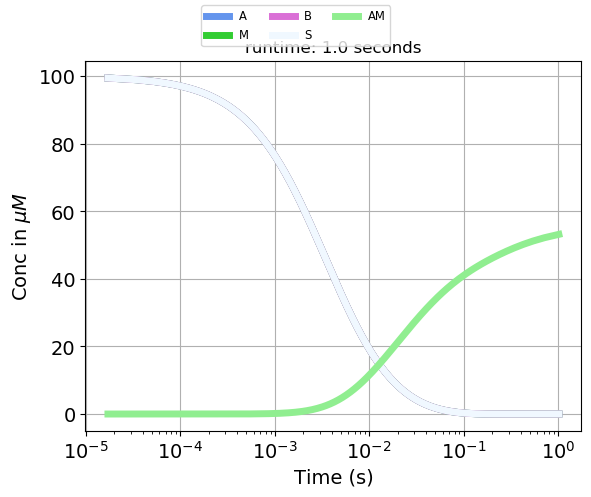

In [6]:
from matplotlib import pyplot as plt
%matplotlib inline
fig, ax = plt.subplots()
# nodes_list = ['A','B','M','S','AB','AM','AS','MS','BM','ABM','AMS','ABS','BMS','ABMS']
# nodes_list_repeat = ['A','B','S','AB','AS','AA','BS','ABS','AAB','AAS','AABS']
sim.plot_observable(nodes_list, ax=ax,legend=False,seed=201,lw=5)
ax.set_title("runtime: " + str(runtime) + " seconds")
handles,labels = ax.get_legend_handles_labels()
ax.set_xscale("log")
fig.legend(handles,nodes_list,loc='upper center',fancybox=True,ncol=3,fontsize='small',markerscale=1.0)
ax.grid(which="major",axis="both")

In [7]:
times=[]
print("Efficiency: ",(y[1][-2]*torch.max(new_kon)*100))
print("Scale Efficiency: ",0.95/(y[1][-2]*torch.max(new_kon)*100))
for t in y[1]:
    try:
        times.append(t.item())
    except:
        times.append(t)
print("Times: ",times)
print(list(new_kon.detach().numpy()))

Efficiency:  tensor(-1000., dtype=torch.float64, grad_fn=<MulBackward0>)
Scale Efficiency:  tensor(-0.0009, dtype=torch.float64, grad_fn=<MulBackward0>)
Times:  [-1, -1, -1, -1]
[0.9736152235284842, 0.9736152235284842, 0.9736152235284842, 0.9736152235284842, 0.9736152235284842, 10.0, 10.0, 0.9736152235284842, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0]


In [8]:
conc_class ={i:0 for i in range(1,5)}
labels={1:'Monomers',2:'Dimers',3:'Trimers',4:'Tetramer'}
for n in rn.network.nodes():
    species=gtostr(rn.network.nodes[n]['struct'])
    len_s=len(species)
    
    conc_class[len_s]+= vec_rn.copies_vec[n].item()
    
for l,conc in conc_class.items():
    print(labels[l],"--","%.3f" %conc)

Monomers -- 0.001
Dimers -- 4.380
Trimers -- 59.471
Tetramer -- 53.206


In [9]:
# print(asdfaf)

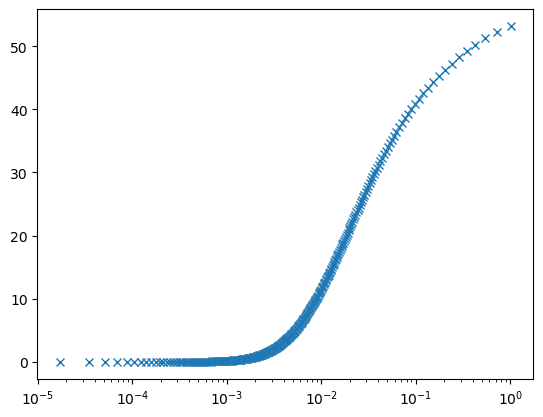

In [10]:
complx_conc = sim.observables[14][1]

fig,ax = plt.subplots()
ax.plot(sim.steps,complx_conc,linestyle='',marker='x')
ax.set_xscale("log")

In [11]:
def only_jumps(time,conc,mod_time):
    min_d = 2700
    max_d=3000
    filter_time=[]
    filter_conc=[]
    down_slope_array=[5.0]
    actual_slope_array=[]
    i=0
    jump_flag=False
    down_flag=False
    high_slope = 87.0
    down_slope = 5.0
    while True:
        del_c = conc[i+1]-conc[i]
        del_t = np.log(time[i+1]/time[i])
        
        slope = del_c/del_t
        angle = np.degrees(np.arctan(slope))
        
        #Checking for transitions
        if abs(angle - high_slope)<2.0:
            high_slope = angle
            jump_flag=True
            if conc[i]>85.0:
                print("Jump Slope:",angle,time[i])
            
        if jump_flag:
            filter_time.append(time[i])
            filter_conc.append(conc[i])
            jump_flag=False
            
            if conc[i]>85.0:
                print(angle,time[i])
            
        i+=1
        if i == len(time)-1:
            print("Last slope: ",angle,time[i],high_slope)
            break
    return(filter_time,filter_conc)

def convert_time_interval(time,conc,time_int=0.1):
    start_time=time[0]
    time_array = []
    conc_array = []
    for i in range(len(time)):
        new_time=time[i]
        ts = new_time/start_time
        if ts>=time_int:
            time_array.append(time[i])
            conc_array.append(conc[i])
            start_time=new_time
    return(time_array,conc_array)
        

In [12]:
# mod_time = sim.mod_start.item()
# print(mod_time)
# mod_time = 1
time_arr = np.array(sim.steps)
complx_conc = np.array(complx_conc)
# sel_time = (time_arr >= mod_time)
# sel_indx = np.argwhere(sel_time)[0][0]
# print(time_arr[sel_indx-1])
# filter_time,filter_conc=filter_data(time_arr[sel_indx-1:],complx_conc[sel_indx-1:],mod_time)

# filter_time,filter_conc=only_jumps(time_arr[sel_indx-3:],complx_conc[sel_indx-3:],mod_time)
# final_time = np.concatenate((time_arr[:sel_indx-3],filter_time[::25]))
# final_conc = np.concatenate((complx_conc[:sel_indx-3],filter_conc[::25]))

# final_time = final_time
# final_conc = final_conc

# print(filter_time[-1],filter_conc[-1])

# final_time = time_arr
# final_conc = complx_conc

sel_time = (time_arr >= 1e-3)
sel_indx = np.argwhere(sel_time)[0][0]

filter_time,filter_conc = convert_time_interval(time_arr[sel_indx-1:],complx_conc[sel_indx-1:],time_int=1.3)
final_time = np.concatenate((time_arr[:sel_indx],filter_time[:]))
final_conc = np.concatenate((complx_conc[:sel_indx],filter_conc[:]))

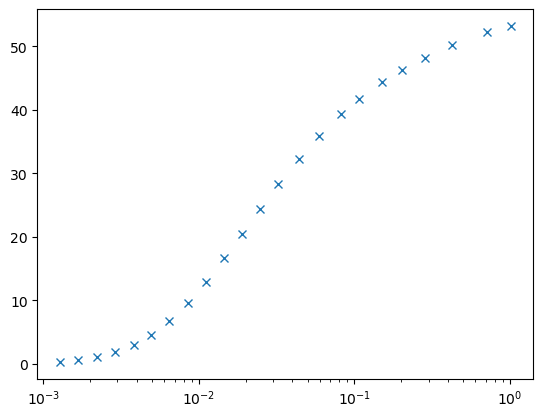

In [13]:
fig,ax = plt.subplots()
ax.plot(filter_time[:],filter_conc[:],linestyle='',marker='x')
ax.set_xscale("log")

(283,)


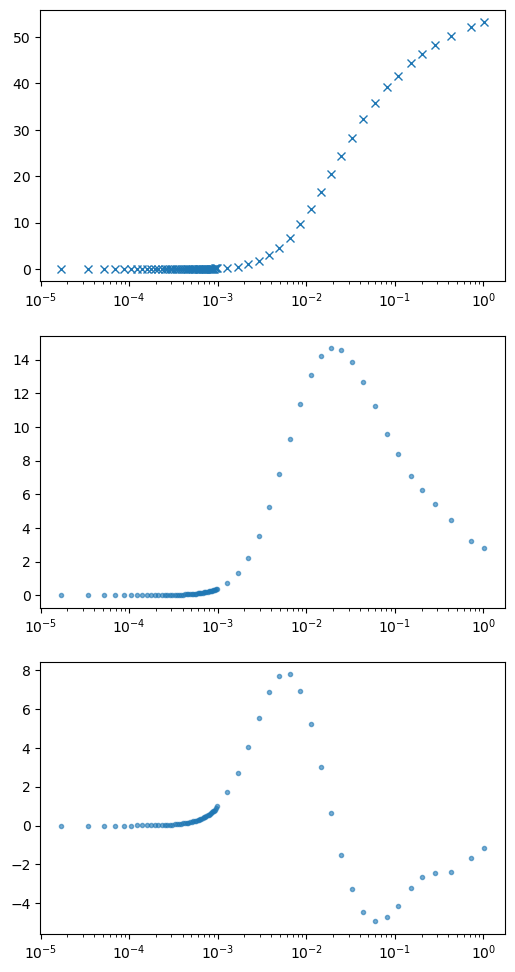

In [14]:
trap_met = TrapMetric(sim)

# lag,time_bounds = trap_met.calc_lag(np.array(sim.steps),np.array(sim.observables[14][1]),99.9)
time_arr = np.array(sim.steps)
print(time_arr.shape)
# mask = time_arr < 1e5
# print("Lag : ",lag)
# print(np.array(sim.steps))
# print(time_arr[mask])
fig,[ax1,ax2,ax3] = plt.subplots(3,1,figsize=(6,12))
ax1.plot(final_time,final_conc,linestyle='',marker='x')
# ax1.vlines(time_bounds[0],ymin=0,ymax=100,color='k',linestyle='--')
# ax1.vlines(time_bounds[1],ymin=0,ymax=100,color='r',linestyle='--')
# ax1.vlines(time_bounds[2],ymin=0,ymax=100,color='g',linestyle='--')
ax1.set_xscale("log")

#Clean Version GRAD1
clean_time1 = time_arr

# l_grad2_unclean = trap_met.calc_slope(clean_time1,l_grad,mode='log')
# clean_time2,l_grad2 = trap_met.clean_data(clean_time1,l_grad2_unclean,mode='hist')
# l_grad3 = trap_met.calc_slope(clean_time2,l_grad2,mode='log')
# mask = (clean_time < 183) & (clean_time>181)

#Uncleaned version - GRAD1
l_grad_unclean = trap_met.calc_slope(final_time,final_conc,mode='log')

#Clean Version - GRAD2
# clean_time2,l_grad2 = trap_met.clean_data(clean_time1,l_grad,mode='hist')

#Unclean Version - GRAD2
l_grad2_unclean = trap_met.calc_slope(final_time,l_grad_unclean,mode='log')

ax2.plot(final_time[:],l_grad_unclean[:],linestyle='',marker='.',alpha=0.6)
# ax2.plot(np.array(sim.steps)[:],np.degrees(np.arctan(l_grad[:])),linestyle='',marker='.',alpha=0.6)
# ax2.vlines(time_bounds[0],ymin=0,ymax=100,color='k',linestyle='--')
# ax2.vlines(time_bounds[1],ymin=0,ymax=100,color='r',linestyle='--')
# ax2.vlines(time_bounds[2],ymin=0,ymax=100,color='g',linestyle='--')
ax2.set_xscale("log")

ax3.plot(final_time[:],l_grad2_unclean[:],linestyle='',marker='.',alpha=0.6)
# ax3.vlines(time_bounds[0],ymin=0,ymax=10,color='k',linestyle='--')
# ax3.vlines(time_bounds[1],ymin=0,ymax=10,color='r',linestyle='--')
# ax3.vlines(time_bounds[2],ymin=0,ymax=10,color='g',linestyle='--')
ax3.set_xscale("log")



[43  5  1  0  1  0  0  1  0  1  0  1  1  0  0  1  0  1  1  0  0  1  0  0
  2  0  0  0  1  0  0  1  1  0  0  0  0  0  2  0  0  0  0  1  1  0  0  1
  1  2]


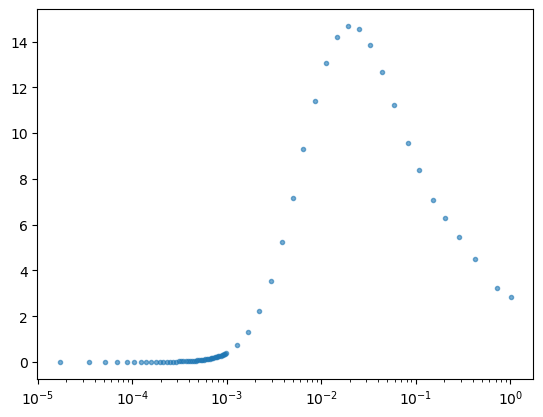

In [15]:
#Analysing GRAD1

l_grad_unclean = trap_met.calc_slope(final_time,final_conc,mode='log')
# step_size=[]
# for i in range(len(time_arr)-1):
#     delta = time_arr[i+1]-time_arr[i]
#     step_size.append(delta)
# remove_indx = []
# for i in range(len(step_size)-1):
#     delta = step_size[i+1]-step_size[i]
#     if delta < 0:
#         remove_indx.append(i)
# mask_bool = np.ones((len(time_arr)),dtype='bool')
# for i in range(len(remove_indx)):
#     mask_bool[remove_indx[i]:remove_indx[i]+1]=False
# clean_time1 = time_arr[mask_bool]
# l_grad = l_grad_unclean[mask_bool]

# clean_time1,l_grad=trap_met.clean_data(final_time,l_grad_unclean,mode='hist')

def clean_data(time,l_grad,thresh_freq=1,bin_num=50):
    data=np.histogram(l_grad,bins=bin_num)
    print(data[0])
    # print(data)
    flag=False
    count=0
    bin_val_min=0
    bin_val_max=0
    for i in range(len(data[0])):
        if data[0][i] >=10 and not flag:
            flag=True
            count+=1
            bin_val_min = data[1][i]
        elif data[0][i] <=1 and flag:
            count+=1
            bin_val_max=data[1][i]
            break

    mask_out = (l_grad <= bin_val_max) & (l_grad >= bin_val_min)
    new_time = np.array(time)[mask_out]
    l_grad_new = l_grad[mask_out]

    return(new_time,l_grad_new)

clean_time1,l_grad = clean_data(final_time,l_grad_unclean)
fig,ax2 = plt.subplots()

ax2.plot(final_time,l_grad_unclean,linestyle='',marker='.',alpha=0.6)
ax2.set_xscale("log")



In [16]:
actual_l_grad = l_grad_unclean
actual_time = final_time

#Finding time points by just visual picking
first_peak_mask = actual_time<1
first_peak_indx = np.argmax(actual_l_grad[first_peak_mask])
first_peak = actual_time[first_peak_mask][first_peak_indx]

second_regime_mask = (actual_time>1)
second_peak_indx = np.argmax(actual_l_grad[second_regime_mask])
second_peak = actual_time[second_regime_mask][second_peak_indx]

valley_mask = (actual_time>first_peak) & (actual_time<second_peak)
min_grad = np.argmin(actual_l_grad[valley_mask])
time_bounds = [first_peak,second_peak]

In [17]:
# print(eq_time)
print(time_bounds)
lag_time = np.log(time_bounds[1]/time_bounds[0])
print("Lag Factor: ",lag_time)

[0.018965898858648675, 1.0157463388363939]
Lag Factor:  3.9807363607915014


In [18]:
min_conc = np.argmin(final_conc[second_regime_mask])

mask_int = (actual_time>20) & (actual_time<1e4)

print("Trapped Yield: ",final_conc[second_regime_mask][min_conc]/10)
print("Avg trapped yield: ",np.mean(final_conc[mask_int])/10)

print("Trapped Yield: ",final_conc[valley_mask][min_grad]/1000)

Trapped Yield:  5.32060354709918
Avg trapped yield:  nan
Trapped Yield:  0.05221125230623059


C:\Users\denys\anaconda3\envs\jhu\lib\site-packages\numpy\core\fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\denys\anaconda3\envs\jhu\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(array([ 2.,  1.,  0.,  1.,  0.,  0.,  2.,  0.,  1.,  2.,  0.,  0.,  1.,
        1.,  1.,  0.,  0.,  0.,  0., 25., 10.,  7.,  6.,  1.,  0.,  0.,
        1.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
        1.,  0.,  1.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  2.]), array([-4.92475046, -4.67065126, -4.41655206, -4.16245287, -3.90835367,
       -3.65425448, -3.40015528, -3.14605608, -2.89195689, -2.63785769,
       -2.3837585 , -2.1296593 , -1.8755601 , -1.62146091, -1.36736171,
       -1.11326251, -0.85916332, -0.60506412, -0.35096493, -0.09686573,
        0.15723347,  0.41133266,  0.66543186,  0.91953105,  1.17363025,
        1.42772945,  1.68182864,  1.93592784,  2.19002703,  2.44412623,
        2.69822543,  2.95232462,  3.20642382,  3.46052301,  3.71462221,
        3.96872141,  4.2228206 ,  4.4769198 ,  4.73101899,  4.98511819,
        5.23921739,  5.49331658,  5.74741578,  6.00151497,  6.25561417,
        6.50971337,  6.76381256,  7.01791176,  7.27201096,  7.52611015,

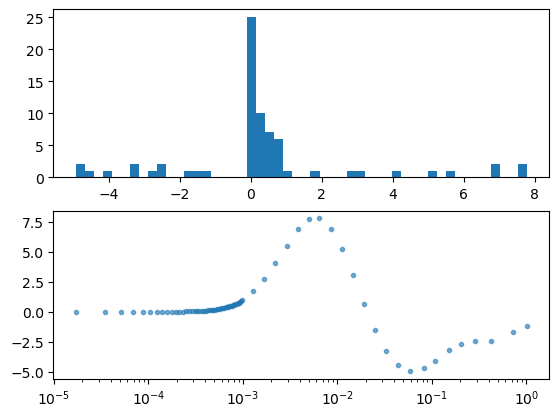

In [19]:
#Analyzing GRAD2
l_grad2_unclean = trap_met.calc_slope(final_time,l_grad_unclean,mode='log')


# data=np.histogram(l_grad2_unclean,bins=50)
# # print(data)
# flag=False
# count=0
# bin_val_min=0
# bin_val_max=0
# for i in range(len(data[0])):
#     if data[0][i] >=10 and not flag:
#         flag=True
#         count+=1
#         bin_val_min = data[1][i]
#     elif data[0][i] <=10 and flag:
#         count+=1
#         bin_val_max=data[1][i]
#         break
# print(bin_val_min,bin_val_max)
# mask_out = (l_grad2_unclean <= bin_val_max) & (l_grad2_unclean >= bin_val_min)
# clean_time2 = np.array(clean_time1)[mask_out]
# l_grad2_new = l_grad2_unclean[mask_out]

# clean_time2,l_grad2_new = trap_met.clean_data(clean_time1,l_grad2_unclean,mode='hist')
# clean_time2,l_grad2_new = trap_met.clean_data(clean_time2,l_grad2_new,mode='hist')
# clean_time2,l_grad2_new = trap_met.clean_data(clean_time2,l_grad2_new,mode='hist')

fig,[ax,ax2] = plt.subplots(2,1)
data_hist=ax.hist(l_grad2_unclean,bins=50)
print(data_hist)
ax2.plot(final_time,l_grad2_unclean,linestyle='',marker='.',alpha=0.6)
ax2.set_xscale("log")

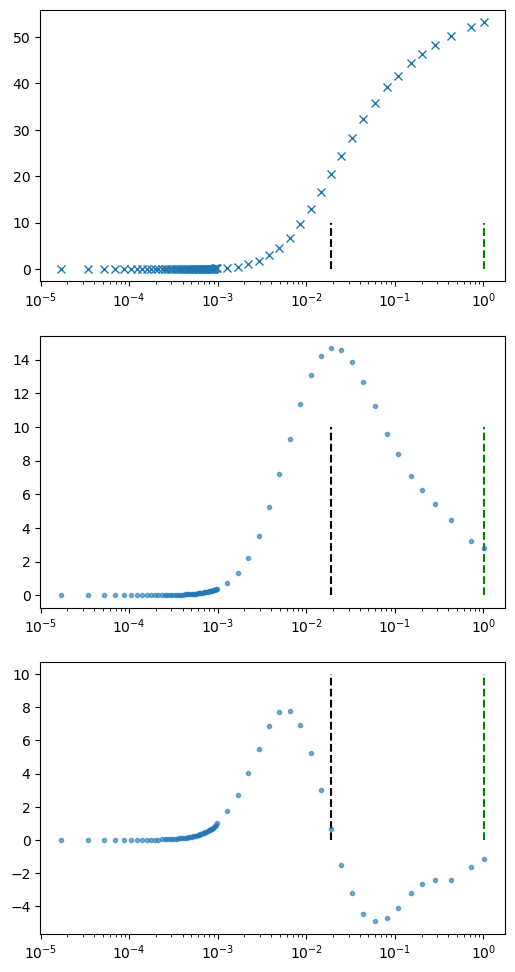

In [20]:
fig,[ax1,ax2,ax3] = plt.subplots(3,1,figsize=(6,12))
ax1.plot(final_time[:],final_conc,linestyle='',marker='x')
ax1.vlines(time_bounds[0],ymin=0,ymax=10,color='k',linestyle='--')
ax1.vlines(time_bounds[1],ymin=0,ymax=10,color='g',linestyle='--')
# ax1.vlines(time_bounds[2],ymin=0,ymax=100,color='g',linestyle='--')
ax1.set_xscale("log")

ax2.plot(final_time[:],l_grad_unclean[:],linestyle='',marker='.',alpha=0.6)
ax2.vlines(time_bounds[0],ymin=0,ymax=10,color='k',linestyle='--')
ax2.vlines(time_bounds[1],ymin=0,ymax=10,color='g',linestyle='--')
# ax2.vlines(time_bounds[2],ymin=0,ymax=20,color='g',linestyle='--')
ax2.set_xscale("log")

ax3.plot(final_time[:],l_grad2_unclean[:],linestyle='',marker='.',alpha=0.6)
ax3.vlines(time_bounds[0],ymin=0,ymax=10,color='k',linestyle='--')
ax3.vlines(time_bounds[1],ymin=0,ymax=10,color='g',linestyle='--')
# ax3.vlines(time_bounds[2],ymin=0,ymax=10,color='g',linestyle='--')
ax3.set_xscale("log")

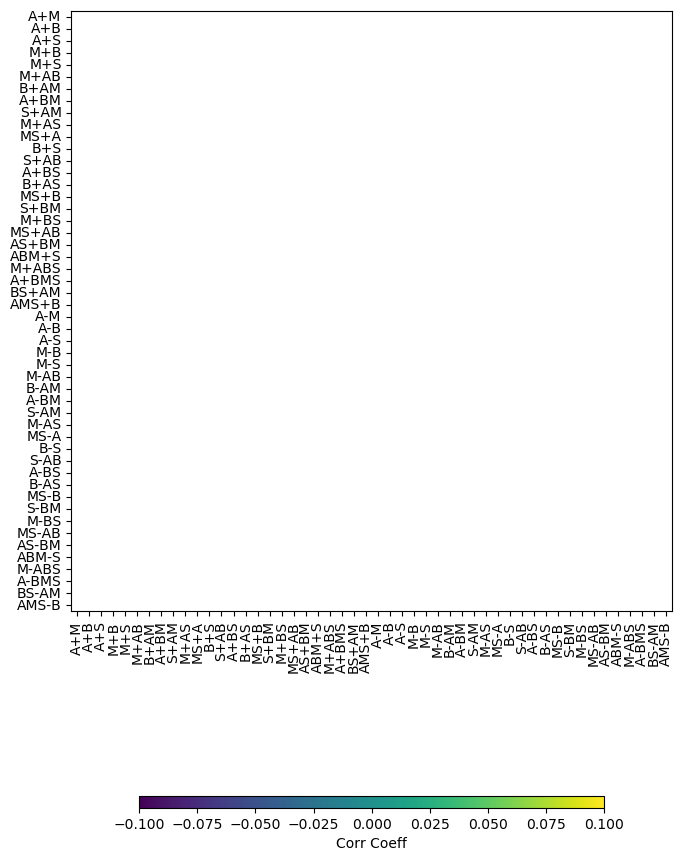

Text(0.5, 1, 'Reaction Fluxes')

In [25]:
#Calculating chemical potential and fluxes
#Calculating correlation b/w fluxes
def corr_matrix(M):
    return(np.corrcoef(M))


flux_corr_matrix = corr_matrix(np.transpose(sim.uid_flux.detach().numpy()))
# print(np.transpose(sim.uid_flux.detach().numpy()))

%matplotlib inline
fig_c,ax_c = plt.subplots(figsize=(12,12))
hm = ax_c.imshow(flux_corr_matrix)


fw_labels=[gtostr(rn.network.nodes[tup[0]]['struct'])+'+'+gtostr(rn.network.nodes[tup[1]]['struct']) for tup in list(react_dict.keys())]
rw_labels=[gtostr(rn.network.nodes[tup[0]]['struct'])+'-'+gtostr(rn.network.nodes[tup[1]]['struct']) for tup in list(react_dict.keys())]
ax_labels = fw_labels+rw_labels
ax_c.set_xticks(np.arange(len(ax_labels)))
ax_c.set_yticks(np.arange(len(ax_labels)))
ax_c.set_xticklabels(ax_labels)
ax_c.set_yticklabels(ax_labels)
plt.setp(ax_c.get_xticklabels(),rotation=90, ha='center',fontsize=10,va='top')
plt.setp(ax_c.get_yticklabels(),va='center',fontsize=10)
fig_c.colorbar(hm,ax=ax_c,aspect=40,label="Corr Coeff",orientation='horizontal',panchor=(0.5,0.0),pad=0.2,shrink=0.5)
# ax_c.grid()

for i in range(len(ax_labels)):
    for j in range(len(ax_labels)):
#         print(ax_labels[j],ax_labels[i])
        ax.text(1.0,1.0,flux_corr_matrix[i,j],ha="center", va="center", color="w",transform=ax.transAxes)
fig.tight_layout()
plt.show()
label = "Reaction Fluxes"
ax_c.set_title(label)

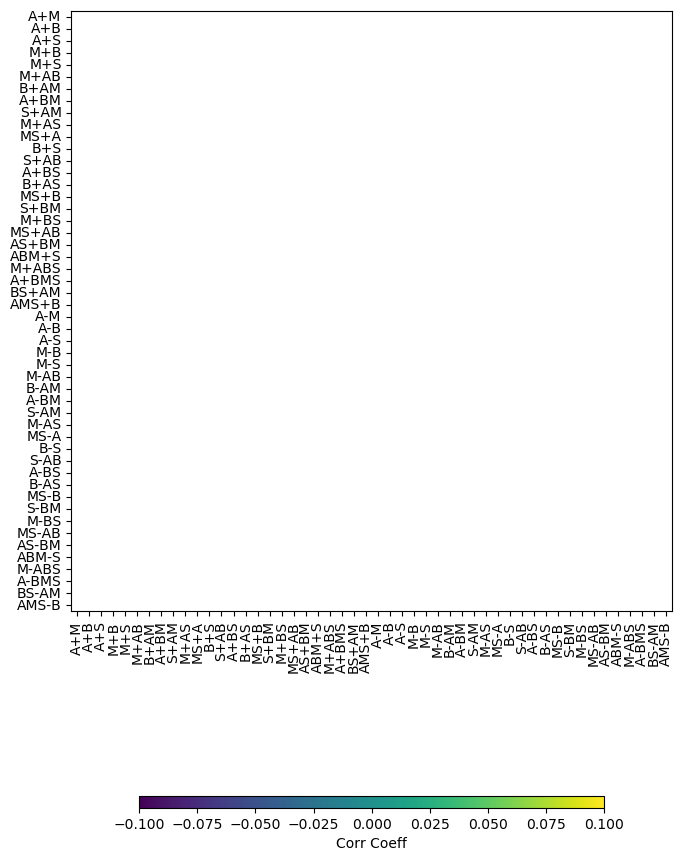

In [26]:
import pickle
import os
pick_path = "./correlation_matrix_reference.pickle"
ref_corr_matrix=np.zeros((2,2))
if os.path.exists(pick_path):
    with open(pick_path,'rb') as pick_handle:
        ref_corr_matrix = pickle.load(pick_handle)
else:
    with open(pick_path,"wb") as pick_handle2:
        pickle.dump(flux_corr_matrix,pick_handle2)

if ref_corr_matrix.all() !=0:
    diff_matrix = flux_corr_matrix-ref_corr_matrix
    fig_diff,ax_diff = plt.subplots(figsize=(12,12))
    hm = ax_diff.imshow(diff_matrix)
    
    fw_labels=[gtostr(rn.network.nodes[tup[0]]['struct'])+'+'+gtostr(rn.network.nodes[tup[1]]['struct']) for tup in list(react_dict.keys())]
    rw_labels=[gtostr(rn.network.nodes[tup[0]]['struct'])+'-'+gtostr(rn.network.nodes[tup[1]]['struct']) for tup in list(react_dict.keys())]
    ax_labels = fw_labels+rw_labels
    ax_diff.set_xticks(np.arange(len(ax_labels)))
    ax_diff.set_yticks(np.arange(len(ax_labels)))
    ax_diff.set_xticklabels(ax_labels)
    ax_diff.set_yticklabels(ax_labels)
    plt.setp(ax_diff.get_xticklabels(),rotation=90, ha='center',fontsize=10,va='top')
    plt.setp(ax_diff.get_yticklabels(),va='center',fontsize=10)
    fig_diff.colorbar(hm,ax=ax_diff,aspect=40,label="Corr Coeff",orientation='horizontal',panchor=(0.5,0.0),pad=0.2,shrink=0.5)

In [23]:
flux_data=sim.uid_flux.detach().numpy()[:-1,:]

In [24]:
#Calculate lag between diff fluxes
from scipy import signal
def calc_lag(x,y):
    corr_array = signal.correlate(x,y,mode='full')
#     lags = signal.correlation_lags(x.size, y.size, mode="full")
#     lag = lags[np.argmax(corr_array)]
#     np_corr_array = np.correlate(x,y,mode='full')
    lag1 = np.argmax(corr_array)-np.floor(corr_array.shape[0]/2)
    corr_coeff = np.corrcoef(x,y,rowvar=False)
    
#     print(corr_array)
#     print(np_corr_array)
#     print(corr_coeff)
#     print("Lag time: ",lag1)
    return(lag1)
    

lag_matrix = np.zeros((flux_data.shape[1],flux_data.shape[1]))
# coeff_matrix = np.zeros(flux_data.shape)
for i in range(flux_data.shape[1]):
    x=flux_data[:,i]
    for j in range(flux_data.shape[1]):
        y=flux_data[:,j]
        lag_matrix[i,j]=calc_lag(x,y)
        

fig_l,ax_l = plt.subplots(figsize=(12,12))
hm = ax_l.imshow(lag_matrix,cmap='inferno')
# fw_labels=list(react_dict.values())
# rw_labels=['-'+str(l) for l in fw_labels]
# ax_labels = fw_labels+rw_labels
fw_labels=[gtostr(rn.network.nodes[tup[0]]['struct'])+'+'+gtostr(rn.network.nodes[tup[1]]['struct']) for tup in list(react_dict.keys())]
rw_labels=[gtostr(rn.network.nodes[tup[0]]['struct'])+'-'+gtostr(rn.network.nodes[tup[1]]['struct']) for tup in list(react_dict.keys())]
ax_labels = fw_labels+rw_labels
ax_l.set_xticks(np.arange(len(ax_labels)))
ax_l.set_yticks(np.arange(len(ax_labels)))
ax_l.set_xticklabels(ax_labels)
ax_l.set_yticklabels(ax_labels)
plt.setp(ax_l.get_xticklabels(),rotation=90, ha='center',fontsize=10,va='top')
plt.setp(ax_l.get_yticklabels(),va='center',fontsize=10)
fig_l.colorbar(hm,ax=ax_l,aspect=40,label="Corr Coeff",orientation='horizontal',pad=0.07,shrink=0.5)
fig_l.tight_layout()
    

ValueError: math domain error

In [ ]:
node_map = {}
for node in rn.network.nodes():
    node_map[gtostr(rn.network.nodes[node]['struct'])] = node

print(node_map)
def get_max_edge(n):
    """
    Calculates the max rate (k_on) for a given node
    To find out the maximum flow path to the final complex starting from the current node.
    
    Can also calculate the total rate of consumption of a node by summing up all rates. 
    Can tell which component is used quickly.
    """
    try:
        edges = rn.network.out_edges(n)
        #Loop over all edges
        #Get attributes
        kon_max = -1
        next_node = -1

        kon_sum = 0
        total_flux_outedges = 0
        total_flux_inedges = 0
        if len(edges)==0:
            return(False)
            
        for edge in edges:
            data = rn.network.get_edge_data(edge[0],edge[1])
            #print(data)
            #Get uid
            uid = data['uid']

            #Get updated kon
            temp_kon = vec_rn.kon[uid]
            kon_sum+=temp_kon
            
            if temp_kon > kon_max:
                kon_max = temp_kon
                next_node=edge[1]
             
        return(kon_max,next_node,kon_sum)
    except Exception as err:
        raise(err)

        
def get_node_flux(n):
    total_flux_outedges = 0
    total_flux_inedges = 0
    #Go over all the out edges
    edges_out = rn.network.out_edges(n)
    if len(edges_out)>0:

        for edge in edges_out:
            data = rn.network.get_edge_data(edge[0],edge[1])
            #print(data)
            #Get uid
            uid = data['uid']

            #Get updated kon
            temp_kon = vec_rn.kon[uid]

            #Calculate k_off also
            std_c = Tensor([1e6])
            l_kon = torch.log(temp_kon)
            l_koff = (vec_rn.rxn_score_vec[uid] * 1. / (vec_rn._R * vec_rn._T)) + l_kon + torch.log(std_c)
            koff = torch.exp(l_koff)

            #Getting conc. of reactants and products
            #Get product
            prod = gtostr(rn.network.nodes[edge[1]]['struct']) 
            #Get other reactant
            react = "".join(sorted(list(set(prod) - set(gtostr(rn.network.nodes[edge[0]]['struct']) ))))

            #Net flux from this edge = Generation - consumption
            edge_flux = koff*vec_rn.copies_vec[edge[1]] - temp_kon*(vec_rn.copies_vec[edge[0]])*(vec_rn.copies_vec[node_map[react]])
            #edge_flux = koff*vec_rn.copies_vec[edge[1]] 

            print("Reaction: ", gtostr(rn.network.nodes[edge[0]]['struct']), "+",react," -> ",prod)
            print("Net flux: ",edge_flux)
            print("kon : ",temp_kon)
            print("koff: ",koff)
            print("Reaction data OUTWARD: ")
            print(data)

            total_flux_outedges+=edge_flux
    
    #Now go over all the in edges
    edges_in = rn.network.in_edges(n)
    react_list = []
    if len(edges_in) > 0:
        for edge in edges_in:
            if edge[0] in react_list:
                continue
            data = rn.network.get_edge_data(edge[0],edge[1])
            uid = data['uid']


            #Get generation rates; which would be kon
            temp_kon = vec_rn.kon[uid]

            #Get consumption rates; which is k_off
            std_c = Tensor([1e6])
            l_kon = torch.log(temp_kon)
            l_koff = (vec_rn.rxn_score_vec[uid] * 1. / (vec_rn._R * vec_rn._T)) + l_kon + torch.log(std_c)
            koff = torch.exp(l_koff)

            #Get conc. of reactants and products
            prod = gtostr(rn.network.nodes[edge[1]]['struct'])
            #Get other reactant
            react = "".join(sorted(list(set(prod) - set(gtostr(rn.network.nodes[edge[0]]['struct']) ))))
            react_list.append(node_map[react])
            #Net flux from this edge = Generation - consumption
            edge_flux_in = temp_kon*(vec_rn.copies_vec[edge[0]])*(vec_rn.copies_vec[node_map[react]])- koff*vec_rn.copies_vec[edge[1]]
            #edge_flux_in = koff*vec_rn.copies_vec[edge[1]]
            


            print("Reaction: ", prod ," -> ",gtostr(rn.network.nodes[edge[0]]['struct']), "+",react)
            print("Net flux: ",edge_flux_in)
            print("kon : ",temp_kon)
            print("koff: ",koff)
            print("Raction data INWARD: ")
            print(data)

            total_flux_inedges+=edge_flux_in
    net_node_flux = total_flux_outedges + total_flux_inedges
    
    return(net_node_flux)
    
pathway = []
kon_sumarray = []
total_con_rate = {}
net_flux = {}
for n in rn.network.nodes():
    
    n_str = gtostr(rn.network.nodes[n]['struct']) 
    
    paths = [n_str]
    kon_sum = 0
    temp_node = n
    max_edge = True
    consumption_rate = 0
    if n < len(rn.network.nodes()):#num_monomers:
#         print("Current node: ")
#         print(n_str)
        while max_edge:
            max_edge = get_max_edge(temp_node)
            if max_edge:
                total_con_rate[gtostr(rn.network.nodes[temp_node]['struct'])] = max_edge[2]
                
                temp_node = max_edge[1]
                kon_sum += max_edge[0].item()
                
                
#                 print("Next node: ")
#                 print(temp_node)

                paths.append(gtostr(rn.network.nodes[temp_node]['struct']))
            else:
                break
        pathway.append(paths)
        kon_sumarray.append(kon_sum)
        paths=[]
    print("-------------------------------------------------------------------------------")
    print("-------------------------------------------------------------------------------")
    print("|                                                                             |")
    node_flux = get_node_flux(n)
    net_flux[gtostr(rn.network.nodes[n]['struct'])] = node_flux
    print("|                                                                             |")
    print("-------------------------------------------------------------------------------")
    print("-------------------------------------------------------------------------------")

print(pathway)
print(kon_sumarray)

#print(total_con_rate)

In [ ]:
# for k,v in sorted(net_flux.items(),key=lambda x : x[1]):
#     print(k," : ", v)

print(vec_rn.copies_vec)
print(vec_rn.kon)

In [ ]:
# for k,v in sorted(total_con_rate.items(),key=lambda x : x[1]):
#     print(k," : ", v.item())

In [ ]:
import networkx as nx
labels = nx.get_node_attributes(rn.network, 'struct')
labels = {key:gtostr(labels[key]) for key in labels.keys()}
# nx.draw_networkx(rn.network,labels=labels,node_size=1000)

In [ ]:
fig,ax = plt.subplots(figsize=(6,6))
sl_pos = nx.shell_layout(rn.network)
nx.draw_networkx(rn.network,pos=sl_pos,labels=labels,node_size=1000,node_color='indianred',ax=ax,edgelist=[])
# new_kon = 0.5*np.array([0.8179, 0.8172, 0.8174, 0.8174, 0.8218, 0.0296, 0.0295, 4.6052, 0.8188,
#         0.8188, 7.7299, 5.4280, 0.8199, 0.8183, 7.1332, 4.9835, 4.9838, 0.0307,
#         0.0315, 5.2260, 5.2278])

if vec_rn.rxn_coupling:
    label_kon = 0.5*sim.coupled_kon.detach().numpy()
else:
    label_kon = 0.5*vec_rn.kon.detach().numpy()
    
sample_colors = ['black','black','black','black','olivedrab','orchid','darkorange','teal','']
edge_widths = []
edge_colors= []
for edge,uid in uid_dict.items():
    edge_widths.append(label_kon[uid])
    #edge_colors.append(sample_colors[uid])
nx.draw_networkx_edges(rn.network,pos=sl_pos,width=edge_widths,label=edge_widths,arrowsize=10,min_target_margin=15.0)


In [ ]:
# fig,ax = plt.subplots(figsize=(6,6))
# nx.draw_networkx(rn.network,pos=sl_pos,labels=labels,node_size=1000,node_color='indianred',ax=ax)

In [ ]:

poly_system = EquilibriumSolver(rn)
solution = poly_system.solve(init_val=vec_rn.copies_vec.detach().numpy().tolist())
#solution = poly_system.solve(verifyBool = False)
if solution == None:
    print("No Equilibrium solution")
else:
    print(solution)
    print("Equilibrium expected yield: ", 100 * solution[-1] / min(vec_rn.initial_copies[:vec_rn.num_monomers]), '%')
print(vec_rn.kon)